In [20]:
import numpy as np 
import pandas as pd 
import netCDF4
import h5py
import pickle 
import os
import evaluation_tools 
import numpy
import PFA

def nc_to_pd(nc):
    Keys = list(nc.keys())
    Panda = {}
    for k in Keys:
        Panda[k]= np.array(nc[k])
    PD = pd.DataFrame( Panda )
    return PD

def rescale( data , ref) :
    means = np.mean(ref , axis = 0 )
    std = np.std( ref , axis =0)
    return (data -means ) / std

def Dict_to_hdf(Dict , of ):
    HDF = h5py.File(of, 'w')
    for k in Dict :    
        test = HDF.create_dataset( k , data = Dict[k] )
    HDF.close()   
ep = 1E-10

def sgn(x , th):
    return ((x - th + ep ) / np.absolute(x - th  +ep)  + 1)/2 

def CSI(  O , M ,th ):
    fo = sgn(O , th)
    fm = sgn(M ,th)
    return np.sum(fo * fm )  /  (np.sum(fo +fm) - np.sum(fo*fm))

def Decode( List, Format ):
    a = [ ]
    for l in List:
        a.append(   l.decode(Format))
    return np.array(a)

# MULTIPLE HDF5 INPUTS

In [2]:

Folder = "D:/Projects/precipitation_AUS/dataset/0025/"
files = os.listdir(Folder)
hdfs = []

for file in files :
    hdf = h5py.File(Folder + file , 'r+')
    hdfs.append( hdf)


In [21]:
needed_keys = [ 'NAME'  , 'LATITUDE' , 'LONGITUDE' ,  'YEAR'  , 'MONTH'   ,  'DAY'  , 'PRCP'  
               ,  'state_code'   , 'state_name'  , 'ant_cat' , 'ACO-MLP' , 'CAL_P'  ,    'PDIR'   ,   'ERA5_tp' ] 
DF = pd.DataFrame()
for k in needed_keys :
    for hdf in hdfs :
        if (k not in list(DF.keys())) and (k in list(hdf.keys())):
            DF[k] = np.array(hdf[k])

In [22]:
DF['NAME']  = Decode(DF['NAME']  , 'utf-8')
DF['state_name']  = Decode(DF['state_name']  , 'utf-8')

In [24]:
DF_qu

,NAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,PRCP,state_code,state_name,CNN3,CNN5,CNN7,CNN3C,CNN5C,CNN7C,ant_
0,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2014,1,1,4.56,4,South Australia,5.731813,4.940254,5.986893,6.454535,7.719248,5.101292,6.665574
1,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2014,1,2,1.44,4,South Australia,4.515442,2.547012,3.706272,4.086087,3.716695,5.638963,5.205596
2,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2014,1,3,0.24,4,South Australia,0.371929,0.247794,0.423590,0.537063,0.413034,0.160669,0.631760
3,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2014,1,4,0.00,4,South Australia,0.316366,0.197666,0.168678,0.406224,0.343166,0.145825,0.583572
4,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2014,1,5,2.40,4,South Australia,1.424639,1.006285,1.535032,0.815280,0.434273,0.847334,2.269346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512030,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,27,0.00,5,Western Australia,-0.018683,0.139017,-0.030714,-0.123759,0.175184,-0.011802,0.000000
1512031,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,28,0.00,5,Western Australia,-0.051789,0.037356,-0.165531,-0.048833,0.297103,0.073037,0.000000
1512032,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,29,0.00,5,Western Australia,-0.127627,0.053902,-0.021857,-0.223015,0.257905,0.081761,0.000000
1512033,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,30,0.00,5,Western Australia,-0.021728,-0.027722,0.007357,-0.170478,0.229207,0.238481,0.000000


In [4]:
DF['k_lat'] = np.int64( (DF.LATITUDE  -min(DF.LATITUDE)) / 20)   
DF['k_lon'] = np.int64( (DF.LONGITUDE  -min(DF.LONGITUDE)) / 20)  
DF['K'] = DF['k_lat']  * max(DF['k_lon'] +1)  + DF['k_lon']


In [45]:
DF['K'] = DF['state_code']

In [27]:
kk = [  'CAL_P'  ,    'PDIR'   ,   'ERA5_tp'  , 'ERA5_cape' , 'ERA5_t2m'  ,  'ERA5_tcw'] 

ord_Keys = [ 'CNN3' ,  'CNN5'  ,   'CNN7'  ,   'CNN3C'  , 'CNN5C' , 'CNN7C' ]

# [  'CAL_P'  ,    'PDIR'   ,   'ERA5_tp'  , 'ERA5_cape' , 'ERA5_t2m'  ,  'ERA5_tcw']  

'''[  'CAL_P'  ,    'PDIR(0)'   ,   'ERA5_tp'  , 'ERA5_cape' , 'ERA5_t2m'  ,  'ERA5_tcw']    +
[k_ +'_ave_box(5, 5)'  for k_ in kk] +
[k_ +'_std_box(5, 5)'   for k_ in kk]  +
[k_ +'_Ci_box(5, 5)'   for k_ in kk]  +
[k_ +'_Cj_box(5, 5)'   for k_ in kk] +
[k_ +'_ave_box(7, 7)'  for k_ in kk] +
[k_ +'_std_box(7, 7)'   for k_ in kk] + 
[k_ +'_Ci_box(7, 7)'   for k_ in kk]  + 
[k_ +'_Cj_box(7, 7)'   for k_ in kk] +
[k_ +'_ave_box(3, 3)'  for k_ in kk] +
[k_ +'_std_box(3, 3)'   for k_ in kk]  +
[k_ +'_Ci_box(3, 3)'   for k_ in kk]  + 
[k_ +'_Cj_box(3, 3)'   for k_ in kk]   ][0]'''



"[  'CAL_P'  ,    'PDIR(0)'   ,   'ERA5_tp'  , 'ERA5_cape' , 'ERA5_t2m'  ,  'ERA5_tcw']    +\n[k_ +'_ave_box(5, 5)'  for k_ in kk] +\n[k_ +'_std_box(5, 5)'   for k_ in kk]  +\n[k_ +'_Ci_box(5, 5)'   for k_ in kk]  +\n[k_ +'_Cj_box(5, 5)'   for k_ in kk] +\n[k_ +'_ave_box(7, 7)'  for k_ in kk] +\n[k_ +'_std_box(7, 7)'   for k_ in kk] + \n[k_ +'_Ci_box(7, 7)'   for k_ in kk]  + \n[k_ +'_Cj_box(7, 7)'   for k_ in kk] +\n[k_ +'_ave_box(3, 3)'  for k_ in kk] +\n[k_ +'_std_box(3, 3)'   for k_ in kk]  +\n[k_ +'_Ci_box(3, 3)'   for k_ in kk]  + \n[k_ +'_Cj_box(3, 3)'   for k_ in kk]   ][0]"

In [28]:

obs_key = 'PRCP'

Rescale = False

# 3 :  [  'IMERG' , 'ERA5_precipitation'  ,'BT 89 V', 'BT 89 H','BT 18 H', 'BT 18 V' ,'DEM', 'Slope', 'Aspect'    ]  ,  'LSTM_RA_3(-3)'

# 2 :   [ 'IMERG' , 'ERA5_precipitation'  ,'BT 89 V', 'BT 89 H','BT 18 H', 'BT 18 V'    ] 

# 1 : [ 'IMERG' , 'ERA5_precipitation' ] 

# ens : [ 'ANN_1', 'ELM_1', 'RF_1']


for k in ord_Keys:
    for hdf in hdfs:
        if k in list(hdf.keys()):
            DF[k] = np.array(hdf[k])

df= {}

df['train'] = DF[DF['YEAR']  <=2020 ]

df['test'] = DF[DF['YEAR']  > 2020 ]

X = {}
X['train'] = df['train'][ ord_Keys  ].values
X['test'] = df['test'][ ord_Keys  ].values


obs_train  = np.array(df['train'][obs_key])
obs_test = np.array(df['test'][obs_key])

if Rescale:
    x_train = rescale(  X['train'] ,  X['train'] )
    x_test = rescale(  X['test']   ,  X['train'])
    DF_X = rescale(DF[ord_Keys] ,  X['train'])
else:
    x_train =  np.array(X['train'] ,)
    x_test = np.array(X['test'] )
    
    DF_X = DF[ord_Keys]


# Multi-variate linear regression

In [12]:
import numpy 

class MLR :
    def __init__(self, constant = False):
        self.instruction = 'Multi-variate linear regression'
        self.cons = constant
    
    def add_constant(self , XX ):
        if  self.cons :
            c = np.zeros( (XX.shape[0] , 1) )+1
            return  np.concatenate((XX, c), 1)
        else: 
            return XX

    def fit(self, X, y):
        
        X = self.add_constant(X)

        print( self.instruction)

        n = X.shape[0]
        
        A = numpy.dot( X.T ,X)/n
        
        A_inv = numpy.linalg.inv(A)
        
        B = numpy.dot(y , X)/n
        
        self.coef = numpy.dot(B,A_inv)
        self.cache = (A,B)

    def predict(self, x_) :
        x_ = self.add_constant(x_)
        return  numpy.dot( self.coef , x_.T )
   


In [28]:

mlr = MLR( constant = True)
mlr.fit( X = x_train , y = obs_train)
z = mlr.predict(x_train)
np.corrcoef( z , obs_train)


Multi-variate linear regression


array([[1.        , 0.75335926],
       [0.75335926, 1.        ]])

In [29]:
z = mlr.predict(x_test)
np.corrcoef( z , obs_test)


array([[1.        , 0.69971798],
       [0.69971798, 1.        ]])

In [30]:
out = evaluation_tools.evaluation_criteria(obs_test , z)


# Quantile Regression

In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt



In [9]:
DF.keys()


Index(['NAME', 'LATITUDE', 'LONGITUDE', 'YEAR', 'MONTH', 'DAY', 'PRCP',
       'CNN_RA_C_[-1](7,7)', 'LSTM_RA_3(-3)', 'CNN_RA_C_(7,7)'],
      dtype='object')

In [20]:
listx= []
for i in range(x_train.shape[1]):
    listx.append('x' + str(i))
df_train = pd.DataFrame( x_train , columns=listx )
df_test = pd.DataFrame( x_test , columns= listx )
df_train[obs_key] = obs_train
df_test[obs_key] = obs_test
DF_x =  pd.DataFrame(DF[ord_Keys].values , columns=listx)

In [33]:
for q_ in [ 0.8 , 0.9  , 0.95 , 0.99]:
    model_name = 'QR' + str(q_)
    mod = smf.quantreg(  "PRCP  ~ x0 + x1", df_train)
    res = mod.fit(q =q_  ) 
    y_pred = res.predict( df_test )
    DF[model_name] = np.maximum( 0 , res.predict( DF_x ))


# Modelling using PFA optimzation

In [7]:
import PFA 
import cateval

In [8]:
x_train[:,0]

array([6.564692  , 2.965003  , 0.3302952 , ..., 0.39151144, 0.31081256,
       3.2769141 ], dtype=float32)

In [ ]:
np.reshape()

In [14]:

def g(x , w_):
    W = np.array([w_[ 0 : int(len(w_)/2) ]])
    B = np.array((w_[ int(len(w_)/2) : ]))
    np.dot( x, W) + B

    return 
    
def model_predict(x , sol  ):
    w_ = sol[2:]
    y = sol[0] + sol[ 1] * x  +   sol[ 2]* np.tanh( g(x , w_))
    return y

def predict(x , sol):
    #h2 = sol[ 2]*np.tanh( x  + sol[ 3]) 
    y = sol[0] + sol[ 1] * x  +   sol[ 2]*np.tanh( sol[3]* x  + sol[ 4]) 
    # y = sol[0] + sol[ 1] * x  +   sol[ 2]*np.maximum( 0 ,  sol[3]* x  + sol[ 4]) 
    
    # y = sol[0] + sol[ 1] * x  +   sol[ 2]* ( 1 / (1+  np.exp(-(sol[3] * x + sol[4] ))))
    # y = sol[0] + sol[ 1] * x  +   sol[ 2]* ( 1 / (1+  np.exp(-(sol[3] * x + sol[4] ))))
    return y

def fit_f(sol):
    y = predict(x_train[:, 0] , sol)
    return  np.mean((y-obs_train)**2)**0.5 /8 -  CSI(obs_train , y  , 57 )   -  CSI(obs_train , y  , 25 ) 

model = PFA.model( fitness_function =  fit_f  , num_of_parameters= 5 , initialize_iteration= 100  , PFA_iteration=1000 ) 
model.fit()
best_fit = model.best_fit
sol = model.best_sol
y_test = predict(x_test[:, 0 ] , sol)
conv_curve = model.Conv_curve 

In [16]:
best_fit = model.best_fit
sol = model.best_sol
y_test = predict(x_test[:, 0 ] , sol)
conv_curve = model.Conv_curve 

In [17]:
conv_curve

[11.912470759793731,
 0.20849699785029296,
 0.06688765350962789,
 0.06688765350962789,
 0.03874843859784122,
 0.0033461802615453173,
 -0.0073271493744336835,
 -0.0084919212577092,
 -0.01330712818774027,
 -0.01495642794354396,
 -0.017910629388377397,
 -0.01809477389612074,
 -0.01821604851739378]

In [18]:
evaluation_tools.evaluation_criteria(obs_test , y_test)

{'r': 0.7044184584429284,
 'NSE': 0.4710129521961657,
 'RMSE': 5.973537227202,
 'MAE': 1.9511362295051464,
 'MBE': 0.036214166386915284,
 'PBIAS': 1.6949645227683723,
 'KGE': 0.6738048261976717,
 'spearman': 0.6320007588885603,
 'std': 7.08858,
 'obs_std': 8.213136775672716,
 'r_heavy': 0.8273552986423871,
 'NSE_heavy': 0.6599777668058979,
 'RMSE_heavy': 30.665508033005082,
 'MAE_heavy': 22.466613270348017,
 'MBE_heavy': -17.056828072047576,
 'PBIAS_heavy': -36.697416811575124,
 'KGE_heavy': 0.7789999109497866,
 'spearman_heavy': 0.41157222678246536,
 'std_obs_heavy': 28.272168034508795,
 'std_model_heavy': 22.277262,
 'r_ext': 0.8701897305378514,
 'NSE_ext': 0.6626326815587266,
 'RMSE_ext': 57.163043830308624,
 'MAE_ext': 45.682193317107455,
 'MBE_ext': -43.24250563183464,
 'PBIAS_ext': -46.90370224993359,
 'KGE_ext': 0.810565176086395,
 'spearman_ext': 0.36356359115108705,
 'std_obs_ext': 39.68935435534869,
 'std_model_ext': 29.528576,
 'POD': 0.8015315809725665,
 'FAR': 0.3624865163

# ANT COLONY CONTINUOS (ACOR)

In [8]:
import mealpy
from mealpy import ACOR
import numpy as np
from mealpy import FloatVar, ACOR
Sols = {}

In [8]:

f = 'tanh'

def NSE(Model ,Obs):
    return  1 - ( np.sum((Model-Obs)**2) / np.sum((Obs-np.mean(Obs ))**2 ))

def predict(x , sol  ):
    # y = sol[0] * x  +   sol[ 1]*np.maximum( 0 ,  sol[2]* x  + sol[ 3]) 
    # y = sol[0]  * x  +   sol[ 1]* ( 1 / (1+  np.exp(-(sol[2] * x + sol[3] ))))
    # y = x  +   sol[ 0]*np.tanh( sol[1]* x  + sol[ 2]) #sol[0] + sol[1] *
    y =  x  * sol[ 0]   + sol[ 1]*np.tanh(  sol[2]*x  + sol[ 3]) 
    return y

def fit_f(sol):
    y = predict(x_train[:, 0] , sol )
    return  np.mean((y-obs_train)**2)**0.5 /8  -  CSI(obs_train , y  , 25 )   -  CSI(obs_train , y  , 25 )  # 


n_var =4
problem_dict = {
    "bounds": FloatVar(  lb=(-100.,) * n_var, ub=(100.,) * n_var, name="delta"),
    "obj_func": fit_f,
    "minmax": "min",
}



In [25]:

n_var =4
problem_dict = {
    "bounds": FloatVar(  lb=(-100.,) * n_var, ub=(100.,) * n_var, name="delta"),
    "obj_func": fit_f,
    "minmax": "min",
}

model = ACOR.OriginalACOR(epoch=50, pop_size=10, sample_count = 25, intent_factor = 0.5, zeta = 1.0)

g_best = model.solve(problem_dict)
sol = g_best.solution
y_ant = predict(x_test[:, 0 ] , sol)
model_name = 'ANT_CNN_' + f
Sols[model_name] = sol
DF[model_name] =  predict(DF_X.values[: , 0 ] , sol) 


2024/06/03 11:44:15 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: Solving single objective optimization problem.
2024/06/03 11:44:18 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 8.435825242149091, Global best: 8.435825242149091, Runtime: 2.26087 seconds
2024/06/03 11:44:20 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 3.137234750376306, Global best: 3.137234750376306, Runtime: 2.17386 seconds
2024/06/03 11:44:22 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 3.137234750376306, Global best: 3.137234750376306, Runtime: 2.12880 seconds
2024/06/03 11:44:25 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 0.9816609702944279, Global best: 0.9816609702944279, Runtime: 2.20235 seconds
2024/06/03 11:44:27 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 0.9191365538889118, Global best: 0.919136553

In [29]:
import PFA
model = PFA.model( fitness_function =  fit_f  , num_of_parameters= 4 , initialize_iteration= 100  , PFA_iteration=100 ) 
model.fit()


0.6176458776402458: 100%|███████████████████████████████████████████| 99/99 [00:41<00:00,  2.38it/s]


In [17]:
y_ant = predict(x_test[:, 0 ] , sol)


In [18]:
print(f" ANT : Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")

 ANT : Solution: [ 1.35961384 -0.1753076  96.1127113 ], Fitness: -0.03929600300235747


In [19]:
Results = {}
Results[  'ant'   ] =    evaluation_tools.evaluation_criteria(obs_test , y_ant)
Results = pd.DataFrame(Results)
print(Results)

                       ant
r                 0.707153
NSE               0.449082
RMSE              6.096108
MAE               1.948878
MBE               0.371576
PBIAS            17.391200
KGE               0.651954
spearman          0.632001
std               7.624825
obs_std           8.213137
r_heavy           0.818110
NSE_heavy         0.667848
RMSE_heavy       30.308547
MAE_heavy        22.385053
MBE_heavy       -14.885432
PBIAS_heavy     -32.025703
KGE_heavy         0.738351
spearman_heavy    0.412019
std_obs_heavy    28.272168
std_model_heavy  26.163082
r_ext             0.856001
NSE_ext           0.694381
RMSE_ext         54.406887
MAE_ext          43.687362
MBE_ext         -37.127453
PBIAS_ext       -40.270909
KGE_ext           0.763120
spearman_ext      0.369134
std_obs_ext      39.689354
std_model_ext    36.977482
POD               0.913814
FAR               0.508624
BIAS              1.859704
CSI               0.469612
POD_heavy         0.511025
FAR_heavy         0.493351
B

In [28]:
Results

,pfa-mlr,ant-mlr,pfa,ant
r,0.707153,0.707153,0.679899,0.706879
NSE,0.367473,0.459740,0.277515,0.467351
RMSE,6.532039,6.036851,6.981096,5.994177
MAE,4.132656,1.922453,4.361843,1.900714
MBE,2.946097,0.206235,3.070270,0.291772
PBIAS,137.888857,9.652620,143.700645,13.656072
KGE,-0.428318,0.677758,-0.476180,0.656159
spearman,0.632001,0.632001,0.614590,0.632004
std,6.322367,7.444288,7.326430,7.253290
obs_std,8.213137,8.213137,8.213137,8.213137


# Meta Heuristic Neural Network

In [9]:
class MLP :
    def __init__(self, nn_shape , inp_feat ):
        self.nn_shape = nn_shape

        self.inp_feat = inp_feat

        self.W_Shapes = []
        self.B_Shapes = []

        for i in range(len(self.nn_shape)):
            if i == 0 :
                self.W_Shapes .append(  (self.inp_feat,  self.nn_shape[i])    )    
            else:
                self.W_Shapes .append(  (self.nn_shape[i-1],self.nn_shape[i])    )
            self.B_Shapes .append(   self.nn_shape[i] )
        self.W_Shapes.append((self.nn_shape[-1] , 1))
        self.B_Shapes .append(  1 )
        self.w_params =[]

        for I in self.W_Shapes:
            self.w_params.append(  I[0]*I[1]    )

        self.Sum_params = sum(self.w_params ) +sum(self.B_Shapes)
        
    def update(self, solution):
        ii = 0
        self.W = []
        for i in range(len(self.W_Shapes)) : 
            a = np.array(solution[ ii  : ii  + self.w_params[i] ])
            self.W.append( np.reshape(a, self.W_Shapes[i]))
            ii = ii  + self.w_params[i] 
        self.B= []
        for i in range(len(self.B_Shapes)) :
            a = np.array(solution[ ii  : ii  + self.B_Shapes[i] ])
            self.B.append( a )
            ii = ii  +  self.B_Shapes[i]
        self.number_of_layers = len(self.W)
        
    def feed_forward(self , X ):
        for i in range(self.number_of_layers):
            h = numpy.dot(X,numpy.array(self.W[i])) + self.B[i]
            if i!= self.number_of_layers-1:
                #X = numpy.tanh(h)
                X = numpy.maximum(h,0) 
        return X
    

In [10]:
mlp_model = MLP(nn_shape= [ 8, 4 ,2 , 1 ] , inp_feat=  x_train.shape[1])

fo_h = sgn(obs_train , 25)
fo_e = sgn(obs_train , 60)

def CSIg(   fo ,M  , th ):
    fm = sgn(M ,th)
    return np.sum(fo * fm )  /  (np.sum(fo +fm) - np.sum(fo*fm))

def fitness_function( solution  ):
    # solution =  solution/sqrt(number_of_parameters)
    mlp_model.update( solution)
    y  =  mlp_model.feed_forward(x_train)[:, 0]
    return np.mean((y-obs_train)**2)**0.5 /8   -  CSIg(fo_h , y  , 25 )   -  CSIg(fo_e , y  , 60 ) + 2 


In [ ]:
n_var = mlp_model.Sum_params

problem_dict = {
    "bounds": FloatVar(  lb=(-1,) * n_var, ub=(1.,) * n_var, name="delta"),
    "obj_func": fitness_function,
    "minmax": "min",}

model = ACOR.OriginalACOR(epoch=100, pop_size=20, sample_count = 25, intent_factor = 0.5, zeta = 1.0)
g_best = model.solve(problem_dict)

mlp_model.update( g_best.solution)
y_ant = mlp_model.feed_forward(x_test)[:, 0]
evaluation_tools.evaluation_criteria(obs_test , y_ant)

df['test']['ACO-MLPX'] =  y_ant

In [23]:
df['test'] = DF[DF['YEAR']> 2020]


In [30]:
df['test'] 

,NAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,PRCP,state_code,state_name,ACO-MLP,CAL_P,PDIR,ERA5_tp,ant_cat,CNN3,CNN5,CNN7,CNN3C,CNN5C,CNN7C
1013846,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2021,1,1,0.0,4,South Australia,0.155005,0.212751,2.0,1.203765e-07,0.387373,0.182449,-0.053226,-0.029483,0.080075,0.393736,0.072845
1013847,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2021,1,2,0.0,4,South Australia,0.159872,0.000000,0.0,1.128530e-05,0.575479,0.242198,0.204520,0.125959,0.200964,0.409503,0.134703
1013848,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2021,1,3,0.0,4,South Australia,0.156455,0.149505,1.0,2.407531e-07,0.546930,0.246615,0.143848,0.022207,0.087790,0.287642,0.091274
1013849,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2021,1,4,0.0,4,South Australia,0.159318,0.000000,0.0,4.784967e-06,0.656829,0.398426,0.194978,0.177162,0.167677,0.547855,0.127665
1013850,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2021,1,5,0.0,4,South Australia,0.156751,0.000000,0.0,2.106589e-07,0.500218,0.240833,0.086308,0.081542,0.160150,0.325074,0.095033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512030,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,27,0.0,5,Western Australia,0.148345,0.000000,0.0,0.000000e+00,0.000000,-0.018683,0.139017,-0.030714,-0.123759,0.175184,-0.011802
1512031,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,28,0.0,5,Western Australia,0.155020,0.000000,0.0,0.000000e+00,0.000000,-0.051789,0.037356,-0.165531,-0.048833,0.297103,0.073037
1512032,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,29,0.0,5,Western Australia,0.155707,0.000000,0.0,0.000000e+00,0.000000,-0.127627,0.053902,-0.021857,-0.223015,0.257905,0.081761
1512033,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,30,0.0,5,Western Australia,0.168037,0.000000,0.0,0.000000e+00,0.000000,-0.021728,-0.027722,0.007357,-0.170478,0.229207,0.238481


In [31]:

Feb_2022_23 = df['test'][df['test']['YEAR'] == 2022][df['test']['MONTH'] == 2][df['test']['DAY'] ==23  ][df['test']['LATITUDE']  < -24.81 ][df['test']['LATITUDE']  > -37.35] [df['test']['LONGITUDE']  < 154.47][df['test']['LONGITUDE']  > 145.6] 
March_2021_18 = df['test'][df['test']['YEAR'] == 2021][df['test']['MONTH'] == 3 ][df['test']['DAY'] == 18 ][df['test']['LONGITUDE']  > 148][df['test']['LATITUDE']  < -28.6][df['test']['LATITUDE']  > -36]
May_2022_10 = df['test'][df['test']['YEAR'] == 2022][df['test']['MONTH'] == 5][df['test']['DAY'] == 10][df['test']['LONGITUDE'] >  141][df['test']['LATITUDE'] > -28.6]
Jan_2023_16  = df['test'][df['test'] ['YEAR']  == 2023 ][df['test'] ['MONTH']  == 1 ][df['test'] ['DAY']  == 15 ][df['test']['LONGITUDE'] >  141][df['test']['LATITUDE'] > -28.6]
Disasters = { 
     '2022-02-23' : Feb_2022_23, 
     '2021-03-18' : March_2021_18,
     '2022-05-10' : May_2022_10,
     '2023-01-16' : Jan_2023_16
}


C:\Users\S4055367\AppData\Local\Temp\ipykernel_28800\2194436812.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Feb_2022_23 = df['test'][df['test']['YEAR'] == 2022][df['test']['MONTH'] == 2][df['test']['DAY'] ==23  ][df['test']['LATITUDE']  < -24.81 ][df['test']['LATITUDE']  > -37.35] [df['test']['LONGITUDE']  < 154.47][df['test']['LONGITUDE']  > 145.6]
C:\Users\S4055367\AppData\Local\Temp\ipykernel_28800\2194436812.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Feb_2022_23 = df['test'][df['test']['YEAR'] == 2022][df['test']['MONTH'] == 2][df['test']['DAY'] ==23  ][df['test']['LATITUDE']  < -24.81 ][df['test']['LATITUDE']  > -37.35] [df['test']['LONGITUDE']  < 154.47][df['test']['LONGITUDE']  > 145.6]
C:\Users\S4055367\AppData\Local\Temp\ipykernel_28800\2194436812.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Feb_2022_23 = df['test'][df['test']['YEAR'] == 2022][df['test']['MON

In [33]:
# overal Evaluation 
out_result ={}
df_test = df['test']
for m in [   'CAL_P' , 'PDIR'  , 'ERA5_tp'  ,  'CNN3' ,'CNN5'  ,  'CNN7'  ,  'CNN3C'  ,'CNN5C'  ,  'CNN7C' , 'ACO-MLP'   ,'ant_cat']:
    predicted = np.array(df_test[m])
    obs_test = np.array(df_test['PRCP'])
    if m == 'ERA5_tp' : 
        predicted = predicted *24*1000
    result = evaluation_tools.evaluation_criteria(obs_test ,predicted ) 
    out_result[m] = result
out_result = pd.DataFrame(out_result)
out_result

,CAL_P,PDIR,ERA5_tp,CNN3,CNN5,CNN7,CNN3C,CNN5C,CNN7C,ACO-MLP,ant_cat
r,0.568148,0.389067,0.596399,0.696348,0.688861,0.694464,0.698121,0.679136,0.705259,0.703607,0.698316
NSE,0.003661,-0.384067,0.272288,0.484702,0.471508,0.480060,0.486509,0.460901,0.497298,0.445529,0.449024
RMSE,8.198091,9.662458,7.006303,5.895741,5.970739,5.922234,5.885392,6.030364,5.823236,6.115735,6.096425
MAE,2.501195,2.750997,2.048869,1.878937,1.742919,1.838258,1.804587,1.881134,1.836704,1.887495,1.994948
MBE,0.478239,0.069760,0.207078,0.083779,-0.298563,0.029562,-0.149466,-0.013171,0.078699,0.311332,0.382604
PBIAS,22.383457,3.265023,9.692061,3.921192,-13.973914,1.383638,-6.995577,-0.616474,3.683431,14.571555,17.907384
KGE,0.496499,0.376392,0.569046,0.575565,0.509601,0.599510,0.550976,0.558702,0.580851,0.660850,0.632101
spearman,0.491643,0.394756,0.628714,0.646090,0.643108,0.639567,0.635567,0.624838,0.633539,0.633539,0.520591
std,9.281308,9.204920,7.261195,5.798938,5.319170,6.089621,5.544212,5.725323,5.784251,7.580068,7.303407
obs_std,8.213137,8.213137,8.213137,8.213137,8.213137,8.213137,8.213137,8.213137,8.213137,8.213137,8.213137


In [34]:
# Evaluation for each disaster 

for disaster in Disasters : 
    out_result = {}
    df_test = Disasters[disaster]
    obs_disaster  = np.array(df_test['PRCP'])
    for m in [ 'CAL_P' , 'PDIR'  , 'ERA5_tp'  , 'CNN3' ,'CNN5'  ,  'CNN7'  ,  'CNN3C'  ,'CNN5C'  ,  'CNN7C'  ,  'ACO-MLP' ,  'ant_cat']:
        predicted = np.array(df_test[m])
        if m == 'ERA5_tp' : 
            predicted = predicted *24*1000
        result = evaluation_tools.evaluation_criteria(obs_disaster ,predicted ) 
        out_result[m] = result
    out_result = pd.DataFrame(out_result)
    out_result.to_excel(r'D:\Projects\precipitation_AUS\new_results/'+disaster + '.xlsx')


In [13]:
# save in Dataframe
DF['ACO-MLPX'] =  mlp_model.feed_forward(DF_X)[:, 0]

In [10]:
# Run ACO-MLP for Each Sate
K  = 'state_code'

uniq = np.unique(DF[K])
df_train = df['train']
df_test = df['test']
Train_qu =[]
Test_qu =[]
ant_MODELS =[]

def CSIg(   fo ,M  , th ):
    fm = sgn(M ,th)
    return np.sum(fo * fm )  /  (np.sum(fo +fm) - np.sum(fo*fm))

for k in uniq :
    df_train_qu = df_train[df_train[K] == k ]
    x_train = df_train_qu[ord_Keys]
    df_test_qu = df_test[df_test[K] == k ]

    x_test = df_test_qu[ord_Keys]

    obs_train = df_train_qu[obs_key]
    obs_test = df_test_qu[obs_key]

    mlp_model = MLP(nn_shape= [8  , 4 , 1 ] , inp_feat=  x_train.shape[1])


    fo_h = sgn(obs_train , 25)
    fo_e = sgn(obs_train , 60)

    def fitness_function( solution  ):
        # solution =  solution/sqrt(number_of_parameters)
        mlp_model.update( solution)
        y  =  mlp_model.feed_forward(x_train)[:, 0]
        return np.mean((y-obs_train)**2)**0.5 /8   -  CSIg(fo_h , y  , 25 )   -  CSIg(fo_e , y  , 60 ) + 2 

    n_var = mlp_model.Sum_params

    problem_dict = {
        "bounds": FloatVar(  lb=(-1.,) * n_var, ub=(1.,) * n_var, name="delta"),
        "obj_func": fitness_function,
        "minmax": "min",}

    model = ACOR.OriginalACOR(epoch=150, pop_size=10, sample_count = 25, intent_factor = 0.5, zeta = 1.0)
    g_best = model.solve(problem_dict)

    mlp_model.update( g_best.solution)
    y_ant = mlp_model.feed_forward(x_test)[:, 0]
    df_test_qu['ant_'] = y_ant
    df_train_qu['ant_'] =  mlp_model.feed_forward(x_train)[:, 0]
    Train_qu.append(df_train_qu)
    Test_qu.append(df_test_qu)
    ant_MODELS.append(mlp_model)

    


2024/08/07 03:15:52 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: Solving single objective optimization problem.
2024/08/07 03:15:53 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 1.884292596528066, Global best: 1.884292596528066, Runtime: 1.21419 seconds
2024/08/07 03:15:54 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 1.884292596528066, Global best: 1.884292596528066, Runtime: 1.20804 seconds
2024/08/07 03:15:56 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 1.8165177066148077, Global best: 1.8165177066148077, Runtime: 1.19350 seconds
2024/08/07 03:15:57 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 1.8165177066148077, Global best: 1.8165177066148077, Runtime: 1.24387 seconds
2024/08/07 03:15:58 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 1.8165177066148077, Global best: 1.8165177

In [11]:
Test_qu = pd.concat(Test_qu )
Train_qu = pd.concat(Train_qu )
DF_qu = pd.concat([Test_qu  ,Train_qu ])


In [12]:
DF_qu = DF_qu.sort_index()


In [13]:
evaluation_tools.evaluation_criteria(Test_qu[obs_key].values , Test_qu['ant_'].values )

{'r': 0.6983155604409136,
 'NSE': 0.4490243611619773,
 'RMSE': 6.096425260040906,
 'MAE': 1.9949484497545849,
 'MBE': 0.3826044619393272,
 'PBIAS': 17.907384152140928,
 'KGE': 0.6321007271719656,
 'spearman': 0.5205913973691637,
 'std': 7.303406903617098,
 'obs_std': 8.213136775672714,
 'r_heavy': 0.797098471736189,
 'NSE_heavy': 0.6352287948168631,
 'RMSE_heavy': 31.761922399136637,
 'MAE_heavy': 23.266568450635233,
 'MBE_heavy': -16.41161877593426,
 'PBIAS_heavy': -35.30926220450749,
 'KGE_heavy': 0.7075869290761672,
 'spearman_heavy': 0.4001628482176481,
 'std_obs_heavy': 28.2721680345088,
 'std_model_heavy': 26.609613516463657,
 'r_ext': 0.8231270059101647,
 'NSE_ext': 0.6514044015746918,
 'RMSE_ext': 58.106509940474474,
 'MAE_ext': 46.9199683397662,
 'MBE_ext': -39.69053674170059,
 'PBIAS_ext': -43.05100017382574,
 'KGE_ext': 0.7250083093735027,
 'spearman_ext': 0.3411168585704973,
 'std_obs_ext': 39.68935435534869,
 'std_model_ext': 40.23610941596342,
 'POD': 0.7741044225346781,


In [25]:
DF['ant_cat'] = DF_qu['ant_']

In [26]:
DF

,NAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,PRCP,state_code,state_name,ACO-MLP,CAL_P,PDIR,ERA5_tp,ant_cat
0,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2014,1,1,4.56,4,South Australia,5.230067,42.075459,2.0,0.000156,6.665574
1,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2014,1,2,1.44,4,South Australia,5.970315,0.137634,1.0,0.000123,5.205596
2,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2014,1,3,0.24,4,South Australia,0.161915,0.000000,0.0,0.000016,0.631760
3,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2014,1,4,0.00,4,South Australia,0.160747,0.729596,0.0,0.000008,0.583572
4,ADELAIDE INTERNATIONAL,-34.945000,138.530556,2014,1,5,2.40,4,South Australia,0.247156,0.000000,0.0,0.000055,2.269346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512030,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,27,0.00,5,Western Australia,0.148345,0.000000,0.0,0.000000,0.000000
1512031,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,28,0.00,5,Western Australia,0.155020,0.000000,0.0,0.000000,0.000000
1512032,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,29,0.00,5,Western Australia,0.155707,0.000000,0.0,0.000000,0.000000
1512033,DALWALLINU COMPARISON,-30.283333,116.666667,2024,1,30,0.00,5,Western Australia,0.168037,0.000000,0.0,0.000000,0.000000


In [15]:
#save it

import pickle

with open(f'../models-2/ACO-MLP.pickle', 'wb') as file:
    pickle.dump(mlp_model, file) 


'''
#load it
with open(f'test.pickle', 'rb') as file2:
    s1_new = pickle.load(file2)
'''


"\n#load it\nwith open(f'test.pickle', 'rb') as file2:\n    s1_new = pickle.load(file2)\n"

In [14]:
import pickle
with open(f'../models/BP-ACO/ACO.pickle', 'rb') as file2:
    mlp_model = pickle.load(file2)

AttributeError: Can't get attribute 'fitness_function' on <module '__main__'>

In [10]:
y = mlp_model.feed_forward(x_test)[:, 0]

In [11]:
evaluation_tools.evaluation_criteria( obs_test , y)

{'r': 0.7043278771805371,
 'NSE': 0.44778705886395653,
 'RMSE': 6.103266661352738,
 'MAE': 1.7441512185122785,
 'MBE': 0.019298918319828526,
 'PBIAS': 0.903264803348695,
 'KGE': 0.6945995263740836,
 'spearman': 0.6597992982522481,
 'std': 7.589486721588132,
 'obs_std': 8.213136775672716,
 'r_heavy': 0.8131009341426878,
 'NSE_heavy': 0.6579107856968887,
 'RMSE_heavy': 30.758573989532454,
 'MAE_heavy': 22.916694844888212,
 'MBE_heavy': -15.206283536931457,
 'PBIAS_heavy': -32.7160080850119,
 'KGE_heavy': 0.7980626188723285,
 'spearman_heavy': 0.4121353699763117,
 'std_obs_heavy': 28.272168034508795,
 'std_model_heavy': 26.954341441022315,
 'r_ext': 0.8531883208859378,
 'NSE_ext': 0.6929947946542449,
 'RMSE_ext': 54.5301523574946,
 'MAE_ext': 43.843112473026,
 'MBE_ext': -36.7252860352052,
 'PBIAS_ext': -39.83469172449585,
 'KGE_ext': 0.8344671808895382,
 'spearman_ext': 0.36909833539873926,
 'std_obs_ext': 39.68935435534869,
 'std_model_ext': 38.11000177958315,
 'POD': 0.6079960133477156

In [88]:

pfa = PFA.model( fitness_function =  fitness_function  , num_of_parameters= n_var , initialize_iteration= 400  
                , PFA_iteration=500 ,  alpha =1  , beta=2 , converging_threshold = 0.001  , lb =-2, ub=2 ) 


pfa.fit()
mlp_model.update( pfa.best_sol)
y_pfa = mlp_model.feed_forward(x_test)[:, 0]


optimization:  39%|██████████████████▎                            | 194/499 [04:10<06:49,  1.34s/it]

-0.010396740641341329


optimization:  73%|██████████████████████████████████▍            | 366/499 [07:38<02:47,  1.26s/it]

-0.010938028276665734


optimization:  76%|███████████████████████████████████▌           | 378/499 [07:55<02:51,  1.42s/it]

-0.011825220582792784


optimization:  96%|████████████████████████████████████████████▉  | 477/499 [10:11<00:25,  1.17s/it]

-0.012092397203078142


optimization: 100%|███████████████████████████████████████████████| 499/499 [10:37<00:00,  1.28s/it]


In [89]:
evaluation_tools.evaluation_criteria(obs_test , y_pfa)

{'r': 0.7023118881354589,
 'NSE': 0.44943428182062006,
 'RMSE': 6.094156996734629,
 'MAE': 1.7157173017062946,
 'MBE': -0.12117054642898194,
 'PBIAS': -5.671255143837552,
 'KGE': 0.6841855461114987,
 'spearman': 0.6383515874155448,
 'std': 7.482941161176759,
 'obs_std': 8.213136775672716,
 'r_heavy': 0.8104469986004795,
 'NSE_heavy': 0.6518400080544532,
 'RMSE_heavy': 31.03029741191202,
 'MAE_heavy': 23.231548369404308,
 'MBE_heavy': -15.708234236134684,
 'PBIAS_heavy': -33.795944750241546,
 'KGE_heavy': 0.7830878111332069,
 'spearman_heavy': 0.41218157647580717,
 'std_obs_heavy': 28.272168034508795,
 'std_model_heavy': 27.021371167543,
 'r_ext': 0.8516869612769503,
 'NSE_ext': 0.6892682139790391,
 'RMSE_ext': 54.860111026174145,
 'MAE_ext': 44.19257837298448,
 'MBE_ext': -37.15709288631459,
 'PBIAS_ext': -40.3030582004432,
 'KGE_ext': 0.818018366875441,
 'spearman_ext': 0.36915789293928314,
 'std_obs_ext': 39.68935435534869,
 'std_model_ext': 38.220886246032165,
 'POD': 0.540765412006

In [90]:

with open(f'../models/PFA-NN.pickle', 'wb') as file:
    pickle.dump(mlp_model, file) 

In [91]:
DF['PFA-NN'] = mlp_model.feed_forward(DF_X)[:, 0]

# SVM model
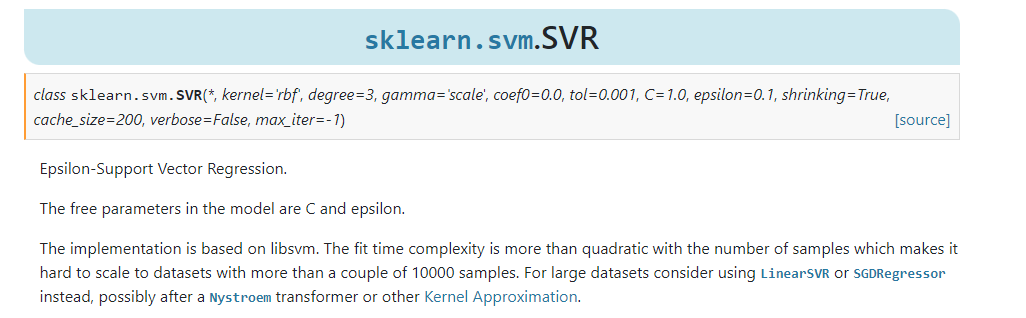

In [81]:
model_name = 'svm_1'

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svr_rbf = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model_func =  svr_rbf.fit( x_train  , obs_train ) 
df['train'][model_name]  = model_func.predict( x_train )
df['test'][model_name]  = model_func.predict( x_test )


# Multi Layer Perception Neural Networks
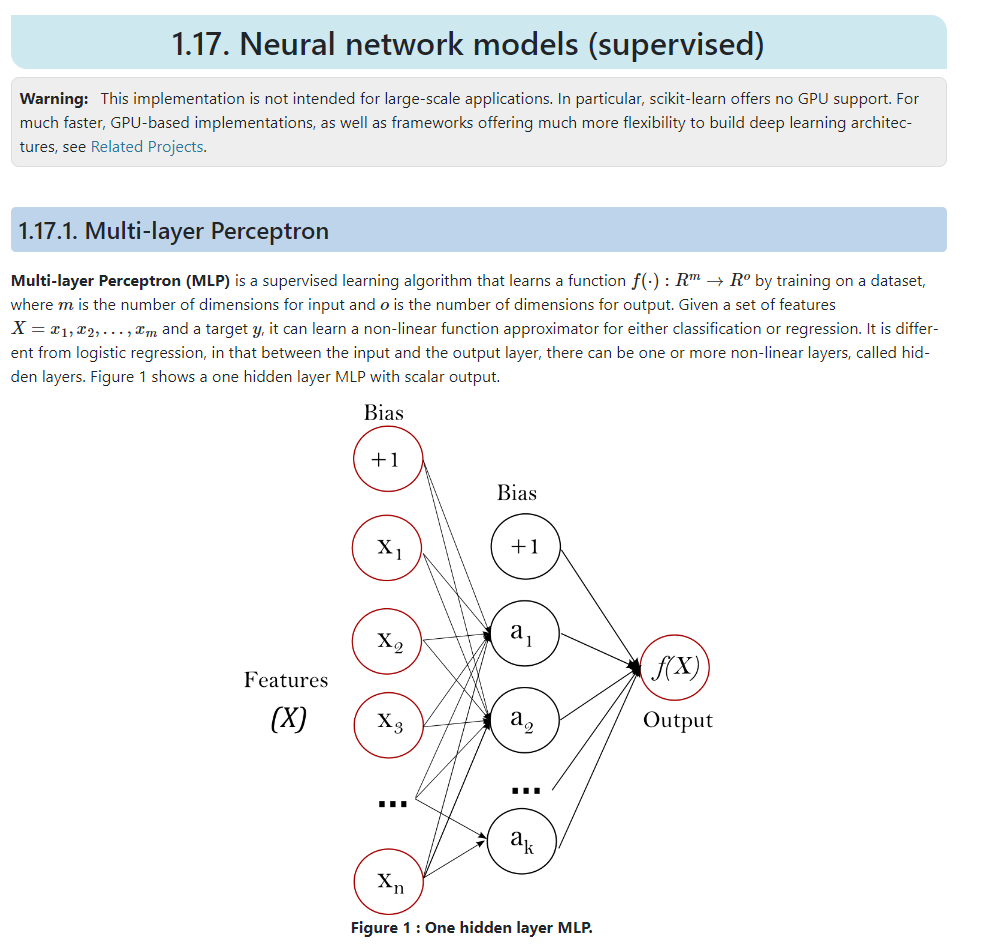

In [10]:
model_name = 'MLP_x'
output_model  = '../models/' + model_name + '.keras'

model_ann = {   
    'n_neorons' :  [ 64] *1 , 
    'act'       :  [ 'relu' ] *5  ,
    'batch'     : 500 , 
    'epoch'     : 5  ,
    'loss_func' :  'mse' , 
    'kernel'    :  "GlorotNormal"  ,
    'optimizer' :   "adam"  ,
    }

from tensorflow.keras.metrics import RootMeanSquaredError 
import keras 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
import numpy

n_layer =  len(model_ann['n_neorons'])

Model=Sequential()

Shape_inp = numpy.shape(x_train)


Model.add(Dense(units= model_ann['n_neorons'][0] , 
                input_dim = Shape_inp[1] , kernel_initializer=model_ann[  'kernel' ] 
                , activation=model_ann['act'][0]))

for i in range(1, n_layer):
    Model.add(Dense(units=model_ann['n_neorons'][i],
                    kernel_initializer=model_ann[  'kernel' ] , 
                    activation = model_ann['act'][i] ))
        
Model.add(Dense(units=1,kernel_initializer=model_ann[  'kernel' ] ))

Model.compile(optimizer= model_ann[ "optimizer" ]  , loss= model_ann[ "loss_func" ]  , metrics=[RootMeanSquaredError()])

Model.fit(  x_train ,  obs_train,  batch_size=model_ann[ "batch" ]  ,  epochs=model_ann[ "epoch" ] )

df['train'][model_name]  = Model.predict( x_train )

df['test'][model_name] =   Model.predict(x_test)

cor = np.corrcoef( df['test'][model_name]  ,  df['test'][obs_key])
cor_cal = np.corrcoef( df['train'][model_name]  ,  df['train'][obs_key]) 
print( 'test = ' , cor[0,1] ,'train = ' , cor_cal[0,1] )


Model.results = evaluation_tools.evaluation_criteria( df['test'][obs_key]   ,df['test'][model_name]  )
print( Model.results)
Model.save(output_model) 




KeyboardInterrupt: 

In [47]:
Model.get_weights

<bound method Layer.get_weights of <Sequential name=sequential, built=True>>

In [34]:
out = evaluation_tools.evaluation_criteria(obs_test , np.array(df['test'][model_name] ))

In [35]:
out

{'r': 0.7019785269291621,
 'NSE': 0.49113281772760087,
 'RMSE': 5.858835130606282,
 'MAE': 1.7648351243152465,
 'MBE': -0.13938062647242722,
 'PBIAS': -6.523558060343844,
 'KGE': 0.5470464083297073,
 'spearman': 0.6305906484474598,
 'std': 5.4633365,
 'obs_std': 8.213136775672716,
 'r_heavy': 0.5509945180480217,
 'NSE_heavy': -0.4512637140449258,
 'RMSE_heavy': 34.059030520463544,
 'MAE_heavy': 26.255092508617413,
 'MBE_heavy': -24.31202301891672,
 'PBIAS_heavy': -52.30682038238388,
 'KGE_heavy': 0.23788661560515467,
 'spearman_heavy': 0.4106279685937792,
 'std_obs_heavy': 28.27216803450867,
 'std_model_heavy': 19.08432960510254,
 'r_ext': 0.49578832497333647,
 'NSE_ext': -1.6062796911147035,
 'RMSE_ext': 64.07439940302359,
 'MAE_ext': 54.61938302507209,
 'MBE_ext': -53.09048165613672,
 'PBIAS_ext': -57.58547307840979,
 'KGE_ext': 0.19366229557836667,
 'spearman_ext': 0.376917358134648,
 'std_obs_ext': 39.689354355348605,
 'std_model_ext': 29.621837615966797,
 'POD': 0.9948905247620309

In [223]:

import pandas as pd
import numpy
from math import *
import hydroeval as he
import scipy.stats as sci
π=3.14159
from cateval import *
import cateval

def scal_eval( Obs , Model ) :
    
    nse  = 1 - ( numpy.sum((Model-Obs)**2) / numpy.sum((Obs-numpy.mean(Obs ))**2 ))
    rmse = numpy.mean((Obs-Model)**2)**0.5
    mbe  = numpy.mean( Model - Obs)
    mae = numpy.mean( numpy.absolute( Model - Obs))
    pbias =  100*numpy.sum(Model-Obs)/numpy.sum(Obs) 
    kge ,r, alpha ,beta = he.evaluator(he.kge, Model, Obs)
    spearman = sci.spearmanr(Obs , Model)[0]
    
    std_obs =  numpy.std(Obs)
    std_model =  numpy.std(Model)
    
    return  { 'r' :  r[0]  , 'rmse' : rmse  , 'nse' :  nse  , 'kge' : kge[0] , 'mbe': mbe , 'mae' :  mae ,  'pbias': pbias  , 'spearman' : spearman , 'std_obs' :  std_obs    , 'std_model' :std_model   }



{'r': 0.6728041348836737, 'NSE': 0.45261353348318667, 'RMSE': 3.531999024301212, 'MAE': 0.918441288973033, 'MBE': -0.01835284957967092, 'PBIAS': -1.9544610297234084, 'KGE': 0.5325395358446561, 'spearman': 0.5532766562537018, 'std': 3.1828227043151855, 'obs_std': 4.773902523187089, 'r_heavy': 0.5284924822952619, 'NSE_heavy': -0.6881673935446269, 'RMSE_heavy': 27.92865849809478, 'MAE_heavy': 21.906356354797104, 'MBE_heavy': -21.130783646934923, 'PBIAS_heavy': -56.37652925044666, 'KGE_heavy': 0.14421775350519228, 'spearman_heavy': 0.3526966741740974, 'std_obs_heavy': 21.495241153142818, 'std_model_heavy': 12.071282386779785, 'r_ext': 0.5981168261740346, 'NSE_ext': -2.8621839932774233, 'RMSE_ext': 53.578529676727875, 'MAE_ext': 48.84843638256344, 'MBE_ext': -48.84843638256344, 'PBIAS_ext': -65.58571111437203, 'KGE_ext': 0.1729010878135787, 'spearman_ext': 0.2425162962248646, 'std_obs_ext': 27.2630419334257, 'std_model_ext': 18.97426986694336, 'POD': 0.9308267552970503, 'FAR': 0.65612769549

In [233]:

t = 'test'
m = 'ANN_month'
ev = evaluation_tools.evaluation_criteria(  df[t]['rrr']  , df[t][m] ) 
print(ev)


{'r': 0.6340024858077296, 'NSE': 0.10713782199751165, 'RMSE': 4.5109265977573925, 'MAE': 1.4489543988012077, 'MBE': 0.8001466382854667, 'PBIAS': 85.21049637574397, 'KGE': 0.06049782956569072, 'spearman': 0.5112933536896948, 'std': 5.49218225479126, 'obs_std': 4.773902523187114, 'r_heavy': 0.4895183462009986, 'NSE_heavy': -0.9078541573895009, 'RMSE_heavy': 29.6903220338216, 'MAE_heavy': 21.081791140547985, 'MBE_heavy': -10.815592980543773, 'PBIAS_heavy': -28.855796558070246, 'KGE_heavy': 0.26975688903924233, 'spearman_heavy': 0.28248685899196513, 'std_obs_heavy': 21.495241153142803, 'std_model_heavy': 30.84993553161621, 'r_ext': 0.5560994489769752, 'NSE_ext': -3.0830152328849714, 'RMSE_ext': 55.088990196385446, 'MAE_ext': 43.61275702582466, 'MBE_ext': -28.614527199485092, 'PBIAS_ext': -38.41891887556229, 'KGE_ext': -0.22011335995342374, 'spearman_ext': 0.08960662578928051, 'std_obs_ext': 27.263041933425697, 'std_model_ext': 56.42338180541992, 'POD': 0.9907561279601164, 'FAR': 0.83042682

In [67]:
np.mean(df['test']['rrr'] *2)   , np.mean(df['train']['rrr'] *2) 

(1.8780471240471377, 1.610185724690455)

# Extreme Learning
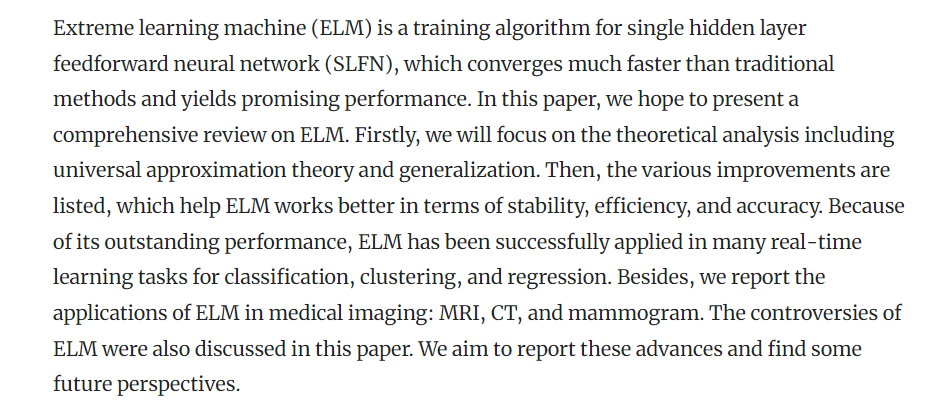

In [37]:
model_name = 'ELM_en'

import numpy as np

output_model  = r'H:/paper/models/' + model_name + '.pkl'

n_hidden_units , activation_func  =  100  , 'relu'


def sig(x):
    return 1.0/(1.0+np.exp(-x))


class ELMRegressor():     
    def __init__(self, n_hidden_units):
        self.n_hidden_units = n_hidden_units
    

    def fit(self, X, labels):
        X = np.column_stack([X, np.ones([X.shape[0], 1])])
        self.random_weights = np.random.randn(X.shape[1], self.n_hidden_units)

        #G = np.tanh(X.dot(self.random_weights))
        G =   np.maximum(X.dot(self.random_weights) , 0 ) 
        self.w_elm = np.linalg.pinv(G).dot(labels)

    def predict(self, X):
        X = np.column_stack([X, np.ones([X.shape[0], 1])])
        G =   np.maximum(X.dot(self.random_weights) , 0 ) 
        # G = np.tanh(X.dot(self.random_weights))
        return G.dot(self.w_elm)


ELM_model = ELMRegressor( n_hidden_units )
ELM_model.fit( x_train , obs_train)


df['train'][model_name]  = ELM_model.predict( x_train )
df['test'][model_name]  = ELM_model.predict(x_test)


cor = np.corrcoef( df['test'][model_name]  ,   obs_test )
print(cor)

ELM_model.ord_keys = ord_Keys


with open(output_model, 'wb') as f:
    pickle.dump(ELM_model, f)


C:\Users\S4055367\AppData\Local\Temp\ipykernel_17468\582429582.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['train'][model_name]  = ELM_model.predict( x_train )


[[1.         0.69739229]
 [0.69739229 1.        ]]


C:\Users\S4055367\AppData\Local\Temp\ipykernel_17468\582429582.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['test'][model_name]  = ELM_model.predict(x_test)


FileNotFoundError: [Errno 2] No such file or directory: 'H:/paper/models/ELM_en.pkl'

In [39]:

cor = np.corrcoef( df['test']['ELM_en'  ]  ,   obs_test )
print(cor)
'Rainf_f_tavg'
'ERA5_precipitation' , 'Rainf_f_tavg' 

[[1.         0.69739229]
 [0.69739229 1.        ]]


('ERA5_precipitation', 'Rainf_f_tavg')

In [41]:
evaluation_tools.evaluation_criteria( obs_test , np.array( df['test']['ELM_en'  ]    ) )

{'r': 0.6973922939704683,
 'NSE': 0.4845086089041444,
 'RMSE': 5.8968456968374925,
 'MAE': 1.7763051973857682,
 'MBE': -0.05762066166047536,
 'PBIAS': -2.696872164596705,
 'KGE': 0.5999947634389609,
 'spearman': 0.6274625974731818,
 'std': 6.076056277130674,
 'obs_std': 8.213136775672716,
 'r_heavy': 0.5423035119175871,
 'NSE_heavy': -0.36651299430079765,
 'RMSE_heavy': 33.049583920315925,
 'MAE_heavy': 25.244789684186035,
 'MBE_heavy': -22.03600567870869,
 'PBIAS_heavy': -47.4100156159183,
 'KGE_heavy': 0.30293414449911193,
 'spearman_heavy': 0.4067575178780674,
 'std_obs_heavy': 28.27216803450867,
 'std_model_heavy': 21.847242510651167,
 'r_ext': 0.4867752823435559,
 'NSE_ext': -1.4044679883025148,
 'RMSE_ext': 61.543690281833285,
 'MAE_ext': 51.96836940332873,
 'MBE_ext': -48.6676662903764,
 'PBIAS_ext': -52.788192902551216,
 'KGE_ext': 0.25018679311637715,
 'spearman_ext': 0.37199827331058793,
 'std_obs_ext': 39.689354355348605,
 'std_model_ext': 34.05389880555975,
 'POD': 0.945618

# Random Forest

In [42]:
model_RF = {
        'type' : 'RF', 
        'Rescale' : True ,
        'number_of_trees' :  20,
        'depth' : 10,
        'min_samples_leaf' : 3  ,
        'random_state'  : 1,
        'n_jobs'  : 5, 
        }

model_name = 'RF_3'

from sklearn.ensemble import RandomForestRegressor

output_model  =  'H:/paper/models/' + model_name + '.joblib'

Model = RandomForestRegressor( n_estimators =  model_RF['number_of_trees'] ,
                            max_depth = model_RF[ 'depth'] , 
                            min_samples_leaf= model_RF[ 'min_samples_leaf']   , 
                            random_state= model_RF[ 'random_state']  ,
                            n_jobs =model_RF[ 'n_jobs']    ,
                            verbose= 1)


Model.fit(x_train ,  obs_train)

df['train'][model_name]  = Model.predict( x_train )

df['test'][model_name]   = Model.predict(x_test)

cor = np.corrcoef( df['test'][model_name]  ,  df['test']['rrr']) 
cor_cal = np.corrcoef( df['train'][model_name]  ,  df['train']['rrr']) 
print( 'test = ' , cor[0,1] ,'train = ' , cor_cal[0,1] )

Model.ord_keys = ord_Keys
Model.hyperparam = model_RF
Model.name_ = model_name
import joblib
joblib.dump(Model, output_model)


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:   26.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.3s finished
C:\Users\S4055367\AppData\Local\Temp\ipykernel_17468\4202110801.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['train'][model_name]  = Model.predict( x_train )
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
C:\Users\S4055367\AppData\Local\Temp\ipykernel_17468\4202110801.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

KeyError: 'rrr'

In [43]:
evaluation_tools.evaluation_criteria( obs_test , np.array( df['test']['RF_3'  ]    ) )

{'r': 0.7073920978971509,
 'NSE': 0.4988473033332015,
 'RMSE': 5.8142552155304745,
 'MAE': 1.724629753931346,
 'MBE': -0.058089742387312356,
 'PBIAS': -2.7188269759213246,
 'KGE': 0.6117066533341322,
 'spearman': 0.6578929349617728,
 'std': 6.12866375027351,
 'obs_std': 8.213136775672716,
 'r_heavy': 0.5358865537778434,
 'NSE_heavy': -0.3497276030287537,
 'RMSE_heavy': 32.84597652885724,
 'MAE_heavy': 24.943440778004458,
 'MBE_heavy': -21.39178807060313,
 'PBIAS_heavy': -46.02399460532089,
 'KGE_heavy': 0.3133671635013364,
 'spearman_heavy': 0.40074346036869973,
 'std_obs_heavy': 28.27216803450867,
 'std_model_heavy': 22.325424562166603,
 'r_ext': 0.468887014485482,
 'NSE_ext': -1.3703460002114105,
 'RMSE_ext': 61.1054443361894,
 'MAE_ext': 51.12874353191621,
 'MBE_ext': -47.498406027425204,
 'PBIAS_ext': -51.51993532994267,
 'KGE_ext': 0.2480873834384878,
 'spearman_ext': 0.3571862001676482,
 'std_obs_ext': 39.689354355348605,
 'std_model_ext': 34.385037940552486,
 'POD': 0.9237237350

# Gradient Boosting 


In [53]:
from sklearn.ensemble import GradientBoostingRegressor as GB

model_name = 'Gradient_Boosting_ensumble'

output_model  =  'H:/paper/models/' + model_name + '.joblib'
Model = GB(    n_estimators=200, learning_rate=0.1, max_depth=1, random_state=1,  loss='squared_error' )
Model.fit(x_train, obs_train)

df['train'][model_name]  = Model.predict( x_train )
df['test'][model_name] =   Model.predict(x_test)

cor = np.corrcoef( df['test'][model_name]  ,  df['test'][obs_key])
print(cor)

import joblib
joblib.dump(Model, output_model)



KeyboardInterrupt: 

# Baysian Model Averaging

In [45]:
from mpmath import mp
mp.dps = 50

class BMA:
    
    def __init__(self, X , y, **kwargs):

        # Setup the basic variables.

        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,1)
        self.coefficients = np.zeros(self.nCols)
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.

        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
            
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_next = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
            if num_elements == 1:
                Models_current = Models_next
                Models_previous = []
            else:
                idx_keep = np.zeros(len(Models_next))
                for M_new,idx in zip(Models_next,range(len(Models_next))):
                    for M_good in Models_previous:
                        if(all(x in M_new for x in M_good)):
                            idx_keep[idx] = 1
                            break
                        else:
                            pass
                Models_current = np.asarray(Models_next)[np.where(idx_keep==1)].tolist()
                Models_previous = []
                        
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]
                if self.RegType == 'Logit':
                    model_regr = sm.Logit(self.y, model_X).fit(disp=0)
                else:
                    model_regr = OLS(self.y, model_X).fit()
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                    
                if (model_likelihood > max_likelihood/20):
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                    self.likelihoods_all[str(model_index_set)] = model_likelihood
                    
                    # Add this likelihood to the running tally of likelihoods.
                    likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)

                    # Add this likelihood (times the priors) to the running tally
                    # of likelihoods for each variable in the model.
                    for idx, i in zip(model_index_set, range(num_elements)):
                        self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=1000)
                        self.coefficients_mp[idx] = mp.fadd(self.coefficients_mp[idx], model_regr.params[i]*model_likelihood, prec=1000)
                    Models_previous.append(model_index_set) # add this model to the list of good models
                    max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                else:
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"rejected by Occam's window")
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            self.coefficients[idx] = mp.fdiv(self.coefficients_mp[idx],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
    def predict(self, data):
        data = np.asarray(data)
        if self.RegType == 'Logit':
            try:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data)))
            except:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data.T)))
        else:
            try:
                result = np.dot(self.coefficients,data)
            except:
                result = np.dot(self.coefficients,data.T)
        
        return result  
        
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  

class BMA_model:
    def __init__(self , *arg):
        self.k = arg 
        print(self.k)
    def fit(self, x ,y):
        x = pd.DataFrame(x , columns = self.k[0])
        self.regr = BMA(x , y).fit()
    def predict(self , x):
        x = pd.DataFrame(x , columns = self.k[0])
        return self.regr.predict(x)


In [48]:
from statsmodels.tools import add_constant
from itertools import combinations
from statsmodels.regression.linear_model import OLS

model_name = 'BMA_ensumble'
output_model  =  'H:/paper/models/' + model_name + '.joblib'

x_df_train = pd.DataFrame(x_train , columns = ord_Keys)
x_df_test = pd.DataFrame(x_test , columns = ord_Keys)

Model =  BMA_model(   ord_Keys )
Model.fit(x_train  , obs_train)


df['train'][model_name]  = Model.predict( x_train )

df['test'][model_name] =   Model.predict(x_test)

cor = np.corrcoef( df['test'][model_name]  ,  df['test'][obs_key])
print(cor)



'''
with open(output_model, 'wb') as f:
    pickle.dump(Model, f)'''


(['CNN_RA_C_[-1](7,7)', 'LSTM_RA_3(-3)', 'LATITUDE', 'LONGITUDE'],)
[[1.         0.69971443]
 [0.69971443 1.        ]]


C:\Users\S4055367\AppData\Local\Temp\ipykernel_17468\1817934424.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['train'][model_name]  = Model.predict( x_train )
C:\Users\S4055367\AppData\Local\Temp\ipykernel_17468\1817934424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['test'][model_name] =   Model.predict(x_test)


"\nwith open(output_model, 'wb') as f:\n    pickle.dump(Model, f)"

In [49]:
evaluation_tools.evaluation_criteria( obs_test , np.array( df['test']['BMA_ensumble'  ]    ) )

{'r': 0.699714429381222,
 'NSE': 0.48821812616542626,
 'RMSE': 5.875590302388049,
 'MAE': 1.7834062801114559,
 'MBE': -0.06866820605624298,
 'PBIAS': -3.2139404194468386,
 'KGE': 0.5988362851331251,
 'spearman': 0.6408046710336,
 'std': 6.04437156619,
 'obs_std': 8.213136775672716,
 'r_heavy': 0.5524047169237561,
 'NSE_heavy': -0.3573697912071929,
 'RMSE_heavy': 32.938832606626946,
 'MAE_heavy': 25.337957059767746,
 'MBE_heavy': -21.999390407094996,
 'PBIAS_heavy': -47.33123860776643,
 'KGE_heavy': 0.3159296776447086,
 'spearman_heavy': 0.4156151693360962,
 'std_obs_heavy': 28.27216803450867,
 'std_model_heavy': 22.36971027073215,
 'r_ext': 0.4908826110135694,
 'NSE_ext': -1.3441262699740912,
 'RMSE_ext': 60.766543694049666,
 'MAE_ext': 51.21546203321906,
 'MBE_ext': -47.633489283143795,
 'PBIAS_ext': -51.666455627797745,
 'KGE_ext': 0.263312896978522,
 'spearman_ext': 0.38063389170844975,
 'std_obs_ext': 39.689354355348605,
 'std_model_ext': 34.58111576586137,
 'POD': 0.98420478272114

In [61]:
x_train

array([[ 0.18003781,  0.07436642,  0.14289555, -0.01105243],
       [ 3.0046932 ,  2.61824391,  3.8946564 ,  3.47304069],
       [ 0.9566338 ,  0.45639396,  1.17871728,  0.38819349],
       ...,
       [-0.2200759 , -0.31142739, -0.24784362, -0.22629452],
       [-0.22189602, -0.28578833, -0.24830652, -0.19841608],
       [-0.22166062, -0.48951246, -0.24840657, -0.20612222]])

In [63]:
add_constant(x_train )

array([[ 1.        ,  0.18003781,  0.07436642,  0.14289555, -0.01105243],
       [ 1.        ,  3.0046932 ,  2.61824391,  3.8946564 ,  3.47304069],
       [ 1.        ,  0.9566338 ,  0.45639396,  1.17871728,  0.38819349],
       ...,
       [ 1.        , -0.2200759 , -0.31142739, -0.24784362, -0.22629452],
       [ 1.        , -0.22189602, -0.28578833, -0.24830652, -0.19841608],
       [ 1.        , -0.22166062, -0.48951246, -0.24840657, -0.20612222]])

# Branched Learning

In [110]:

class Branched_learning :
    def __init__( self, DF  , ord_list   ,  obs  , cat  , name   , model  , **kwargs ):
        # DF :  a dataframe
        # ord_keys : a list of input features 
        # obs_key :  a string of observation key 
        # model : a model function with .fit atribute which gives x , y as inputs 
        # cat_key : a string of categorical feature 
        # model_name : a string for name of model 
        
        self.instruction = { 'DF' : ' a dataframe '
        , 'ord_keys' : 'a list of input features' 
        , 'obs_key' :  'a string of observation key '
        , 'model' : 'a model function with .fit atribute which gives x , y as inputs '
        , 'cat_key' : 'a string of categorical feature '
        , 'model_name' : 'a string for name of model' }
        
        self.Items  =   dict( kwargs.items() ) 
        self.key_item = list(self.Items.keys()) 
        self.kw = kwargs
        self.name = name
        self.model = model
        self.df = DF 
        self.ord_keys = ord_list
        self.obs_key = obs
        self.cat_key = cat

        self.unq = np.unique( self.df [cat])

        self.x_global = np.array( self.df[self.ord_keys]) 
        

    def fit(self):
        
        dfs  = [ ]
        self.MODELS = {}

        for u in self.unq :
            
            df_u = self.df[ self.df[self.cat_key]  == u  ] 

            x = np.array( df_u[self.ord_keys])
            obs_train = np.array( df_u[self.obs_key])

            # x_train = rescale( x , self.x_global )
            x_train = x

            self.model.fit(x_train , obs_train)
            
            df_u[  self.name ] = self.model.predict( x_train )

            dfs.append( df_u )
            
            self.MODELS[u] = self.model 
        self.df_train = pd.concat( dfs  , axis = 0  )

    def predict( self, df_pr ):
        
        dfs = []

        for u in self.unq :
            df_u = df_pr[ df_pr[self.cat_key]  == u  ]

            x = np.array( df_u[self.ord_keys])

            obs_ = np.array( df_u[self.obs_key])

            x_ = MF.rescale(  x ,self.x_global , 'normal' )
            
            df_u[  self.name ] = self.MODELS[u].predict( x_ )

            dfs.append( df_u )
        self.df_ = pd.concat( dfs  , axis = 0  )

        return self.df_



In [115]:
antmlp = ANTCO_MLP( nodes= [8 ,4 ]  , epoch=10  , lb = -1 , ub = 1 )


In [116]:
df_train =DF[DF['YEAR'] <= 2020 ]

BL = Branched_learning(  DF = df_train , ord_list =ord_Keys   ,  obs = 'PRCP'  , cat = 'K'  , name = 'BL-anco-mlp'   , model  = antmlp   )

In [117]:
BL.fit()

2024/06/06 01:34:37 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: Solving single objective optimization problem.
2024/06/06 01:34:40 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 1.877525920976678, Global best: 1.877525920976678, Runtime: 2.07178 seconds
2024/06/06 01:34:42 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 1.115002770993833, Global best: 1.115002770993833, Runtime: 2.00763 seconds
2024/06/06 01:34:44 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 0.8554636149433482, Global best: 0.8554636149433482, Runtime: 1.98815 seconds
2024/06/06 01:34:46 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 0.35906193110898554, Global best: 0.35906193110898554, Runtime: 2.00517 seconds
2024/06/06 01:34:48 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 0.35906193110898554, Global best: 0.3590

ValueError: cannot reshape array of size 4 into shape (1,8)

In [52]:


model_name = 'x'
output_model  = 'H:/paper/models/' + model_name + '.h5'

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from itertools import combinations

#Model = GB(    n_estimators=200, learning_rate=0.1, max_depth=1, random_state=1,  loss='squared_error' )


barnch_learn = Branched_learning(   DF  =   df['train'] , 
                                    ord_list  = ord_Keys  ,  
                                    obs  = obs_key , 
                                    cat  = 'month' , 
                                    name = model_name  , 
                                    model = GB(    n_estimators=300, learning_rate=0.1, max_depth=2, random_state=1,  loss='squared_error' )
                                     )

barnch_learn.fit()

df['train'] = barnch_learn.predict(df['train']) 

df['test'] = barnch_learn.predict(df['test']) 

t = 'test'
m = model_name
ev = evaluation_tools.evaluation_criteria(  df[t][obs_key]  , df[t][m] ) 
print(ev)

NameError: name 'GB' is not defined

In [87]:
model_name = 'ANN_ensumble_month'
output_model  = 'H:/paper/models/' + model_name + '.h5'

model_ann = {   
    'n_neorons' :  [ 64] *5 , 
    'act'       :  [ 'relu' ] *10  ,
    'batch'     : 25 , 
    'epoch'     : 10  ,
    'loss_func' :  'mse' , 
    'kernel'    :  "GlorotNormal"  ,
    'optimizer' :   "adam"  ,
    }

from tensorflow.keras.metrics import RootMeanSquaredError 
import keras 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
import numpy


n_layer =  len(model_ann['n_neorons'])

Model=Sequential()

Shape_inp = numpy.shape(x_train)


Model.add(Dense(units= model_ann['n_neorons'][0] , 
                input_dim = Shape_inp[1] , kernel_initializer=model_ann[  'kernel' ] 
                , activation=model_ann['act'][0]))

for i in range(1, n_layer):
    Model.add(Dense(units=model_ann['n_neorons'][i],
                    kernel_initializer=model_ann[  'kernel' ] , 
                    activation = model_ann['act'][i] ))
        
Model.add(Dense(units=1,kernel_initializer=model_ann[  'kernel' ] ))

Model.compile(optimizer= model_ann[ "optimizer" ]  , loss= model_ann[ "loss_func" ]  , metrics=[RootMeanSquaredError()])

# Model.fit(  x_train ,  obs_train,  batch_size= model_ann[ "batch" ]  ,  epochs=model_ann[ "epoch" ] )


class model_():
    def __init__( self , model_ann , model_obj):
        self.bch= model_ann[ "batch" ]  
        self.ep =model_ann[ "epoch" ]
        self.Model = model_obj
    def fit(self, x_train , obs_train):
        return self.Model.fit( x_train , obs_train  ,  batch_size= self.bch  ,  epochs=self.ep  )
    def predict(self, x):
        return self.Model.predict(x)

M = model_(model_ann , Model  ) 

barnch_learn = Branched_learning(   DF  =   df['train'] , 
                                    ord_list  = ord_Keys  ,  
                                    obs  = obs_key , 
                                    cat  = 'month' , 
                                    name = model_name  , 
                                    model = M
                                     )

barnch_learn.fit()

Epoch 1/10
223/223 [==============================] - 2s 2ms/step - loss: 11.1217 - root_mean_squared_error: 3.3349
Epoch 2/10
223/223 [==============================] - 0s 2ms/step - loss: 8.7755 - root_mean_squared_error: 2.9624
Epoch 3/10
223/223 [==============================] - 0s 2ms/step - loss: 9.1251 - root_mean_squared_error: 3.0208
Epoch 4/10
223/223 [==============================] - 0s 2ms/step - loss: 9.0879 - root_mean_squared_error: 3.0146
Epoch 5/10
223/223 [==============================] - 0s 2ms/step - loss: 9.0160 - root_mean_squared_error: 3.0027
Epoch 6/10
223/223 [==============================] - 0s 2ms/step - loss: 8.4454 - root_mean_squared_error: 2.9061
Epoch 7/10
223/223 [==============================] - 0s 2ms/step - loss: 8.6270 - root_mean_squared_error: 2.9372
Epoch 8/10
223/223 [==============================] - 1s 2ms/step - loss: 9.1939 - root_mean_squared_error: 3.0322
Epoch 9/10
223/223 [==============================] - 0s 2ms/step - loss: 8.596

c:\Users\Reza\anaconda3\envs\Reza\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


196/196 [==============================] - 0s 2ms/step - loss: 10.9669 - root_mean_squared_error: 3.3116
Epoch 2/10
196/196 [==============================] - 0s 2ms/step - loss: 12.0204 - root_mean_squared_error: 3.4670
Epoch 3/10
196/196 [==============================] - 0s 2ms/step - loss: 10.9845 - root_mean_squared_error: 3.3143
Epoch 4/10
196/196 [==============================] - 0s 2ms/step - loss: 11.3445 - root_mean_squared_error: 3.3682
Epoch 5/10
196/196 [==============================] - 0s 2ms/step - loss: 11.4270 - root_mean_squared_error: 3.3804
Epoch 6/10
196/196 [==============================] - 0s 1ms/step - loss: 11.1596 - root_mean_squared_error: 3.3406
Epoch 7/10
196/196 [==============================] - 0s 1ms/step - loss: 10.9542 - root_mean_squared_error: 3.3097
Epoch 8/10
196/196 [==============================] - 0s 1ms/step - loss: 10.6906 - root_mean_squared_error: 3.2696
Epoch 9/10
196/196 [==============================] - 0s 1ms/step - loss: 10.6733 -

In [88]:
df['train'] = barnch_learn.predict(df['train']) 

df['test'] = barnch_learn.predict(df['test']) 

t = 'test'
m =  'ANN_ensumble_month'
ev = evaluation_tools.evaluation_criteria(  df[t]['rrr']  , df[t][m] ) 
print(ev)

 68/153 [============>.................] - ETA: 0s

c:\Users\Reza\anaconda3\envs\Reza\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


150/150 [==============================] - 0s 1ms/step
{'r': 0.6450615707263889, 'NSE': 0.39874763606233843, 'RMSE': 3.7017061926426758, 'MAE': 0.9823038850456715, 'MBE': 0.07324052443071662, 'PBIAS': 7.799647143346212, 'KGE': 0.5730563758350382, 'spearman': 0.5749649960495041, 'std': 3.7041091918945312, 'obs_std': 4.773902523187089, 'r_heavy': 0.5062564428131703, 'NSE_heavy': -0.6570913384305397, 'RMSE_heavy': 27.67040688947303, 'MAE_heavy': 21.406654320541186, 'MBE_heavy': -18.731901090764175, 'PBIAS_heavy': -49.97635617328946, 'KGE_heavy': 0.2901983623916874, 'spearman_heavy': 0.34951354946096236, 'std_obs_heavy': 21.495241153142818, 'std_model_heavy': 19.316682815551758, 'r_ext': 0.4873360489767055, 'NSE_ext': -2.4461117237000676, 'RMSE_ext': 50.610308918130634, 'MAE_ext': 42.94316273650738, 'MBE_ext': -40.299564569165014, 'PBIAS_ext': -54.10768072837827, 'KGE_ext': 0.22992630189020702, 'spearman_ext': 0.15832256636693517, 'std_obs_ext': 27.2630419334257, 'std_model_ext': 32.537227

# Save Output

In [89]:
import xarray


of_train =  r"h:\paper\data\calibration_6.nc4"
of_test = r"h:\paper\data\test_6.nc4"

xr = xarray.Dataset(  df['train']  ) 
xr.to_netcdf( of_train , format="NETCDF4")


xr = xarray.Dataset(  df['test']  ) 
xr.to_netcdf( of_test , format="NETCDF4")



In [91]:

df['train'].to_excel(of_train +'.xlsx' )

df['test'].to_excel(of_test  +'.xlsx' )


In [35]:
for k in ord_Keys  : del DF[k]

In [36]:
for k in ['NAME'  , 'state_name']   : del DF[k]

In [38]:
for k in ['CAL_P'	 ,'PDIR',	'ERA5_tp']  : del DF[k]

In [40]:
Dict_to_hdf(DF, r'../dataset/0025/joint-ant-colony.hdf5')

In [39]:
DF

,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,PRCP,state_code,ACO-MLP,ant_cat
0,-34.945000,138.530556,2014,1,1,4.56,4,5.230067,6.665574
1,-34.945000,138.530556,2014,1,2,1.44,4,5.970315,5.205596
2,-34.945000,138.530556,2014,1,3,0.24,4,0.161915,0.631760
3,-34.945000,138.530556,2014,1,4,0.00,4,0.160747,0.583572
4,-34.945000,138.530556,2014,1,5,2.40,4,0.247156,2.269346
...,...,...,...,...,...,...,...,...,...
1512030,-30.283333,116.666667,2024,1,27,0.00,5,0.148345,0.000000
1512031,-30.283333,116.666667,2024,1,28,0.00,5,0.155020,0.000000
1512032,-30.283333,116.666667,2024,1,29,0.00,5,0.155707,0.000000
1512033,-30.283333,116.666667,2024,1,30,0.00,5,0.168037,0.000000


In [36]:
DF.to_csv(r'../dataset/0024/dataset_2014-2024_0024_QR-joints.csv')

In [ ]:
DF[DF['YEAR'] > 2020 ].to_excel(r'../dataset/0024/dataset_2014-2024_0024_QR-joints.xlsx')

In [68]:
from copulabayesnet import bncopula as bc
import numpy as np
from copulabayesnet.data_preprocessor import CorrMatrix

c:\Users\Reza\anaconda3\envs\Reza\lib\site-packages\skgof\ecdfgof.py:45: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from .cvmdist import cvm_unif


In [73]:
Z = bc.CopulaNd(x_train )

# Model Averaging Test

In [14]:
### Import the required packages
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
import math
import pandas as pd

### Set theme
plt.style.use('seaborn')
sns.set_style("darkgrid")

### Define the colour scheme
c1 = "#173f5f"
c2 = "#20639b"
c3 = "#3caea3"
c4 = "#f6d55c"
c5 = "#ed553b"

print("Imported the required packages successfully!")

Imported the required packages successfully!


In [15]:

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [1]:

X = x_train[: , 0 ].T
Y = obs_train

n=len(x_train)
### Emperical CDF
cdf_y = np.arange(1, n+1) / n
X_cdf_x = np.sort(X)
Y_cdf_x = np.sort(Y)

### Correlation
correlation_sample = np.corrcoef(X, Y)
print("Sample Correlation: {:.1%}".format(correlation_sample[1,0]))

### Expected Value
X_mean = np.mean(X)
Y_mean = np.mean(Y)

X2 = np.square(X)
Y2 = np.square(Y)

### Variance
var = (np.mean(X2)*np.mean(Y2)) - ((np.mean(X)**2)*(np.mean(Y)**2))

print("Sample Expected Value: ({:,.2f},{:,.2f})".format(X_mean, Y_mean))
print("Sample Variance: {:,.2f}".format(var))

### Plot the sampled PDF and CDF against the theoretical distribution
fig, ax = plt.subplots(figsize=(16,6), nrows=1, ncols=2)

ax[0].step(X_cdf_x, cdf_y, where='post', color=c1, label=r"Marginal Distribution $X$")
ax[0].step(Y_cdf_x, cdf_y, where='post', color=c5, label=r"Marginal Distribution $Y$")
ax[0].set(title="Cumulative Distribution Function", xlabel="Random Variates", ylabel="Cumulative Probability")
ax[0].legend()

ax[1].scatter(X, Y, color=c1, alpha=0.7, label="Joint Distribution")
confidence_ellipse(X, Y, ax=ax[1],alpha=0.2, facecolor=c2, edgecolor=c2, zorder=0, label="3 Standard Deviations",)
ax[1].set(title="Joint Distribution Scatter Plot", xlabel="X", ylabel="Y")
ax[1].legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

NameError: name 'x_train' is not defined

-2.1091308119528038e-17

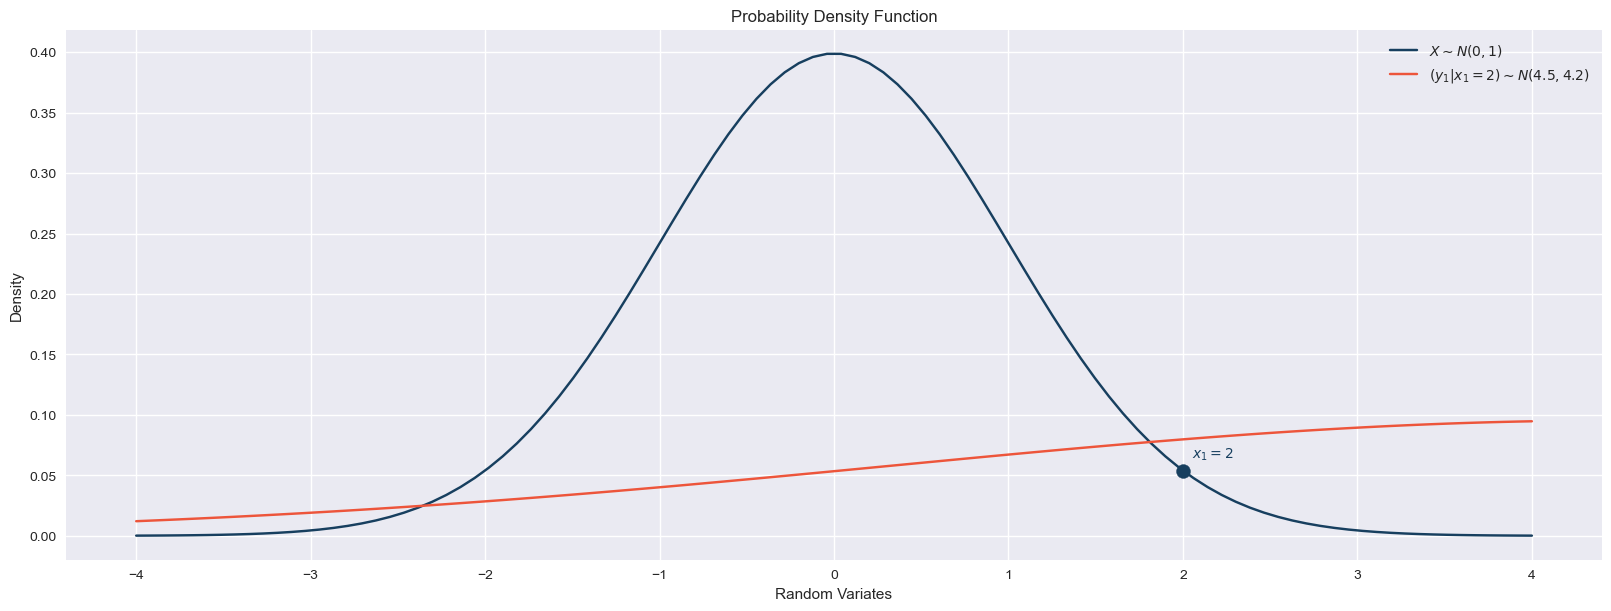

In [49]:
correlation = np.corrcoef(X, Y)[0,1]
x1 = 2

### Fixed Parameters
mu_X = X.mean()
std_X = X.std()

mu_Y = Y.mean()
std_Y = Y.std()



### Theoretical x1 PDF
x1_pdf_x = np.linspace(-4, 4, 100)
x1_pdf_y = sp.stats.norm.pdf(x=x1_pdf_x, loc=0, scale=1)

### Emperical x1 PDF
x1_pdf = sp.stats.norm.pdf(x=x1, loc= mu_X, scale=std_X)

### Expected Value and Standard Deviation of y1
E_y1 = mu_Y + (correlation * std_Y * ( (x1 - mu_X)/std_X) )
std_y1 = std_Y * math.sqrt(1 - correlation**2)

### Theoretical y1 PDF
y1_pdf_x = np.linspace(-4, 4, 100)
y1_pdf_y = sp.stats.norm.pdf(x=y1_pdf_x, loc=E_y1, scale=std_y1)

### Plot the sampled PDF and CDF against the theoretical distribution
fig, ax = plt.subplots(figsize=(16,6))

ax.scatter(x1, x1_pdf, color=c1, s=100, label="_nolabel_")
ax.plot(x1_pdf_x, x1_pdf_y, color=c1, label=r"$X\sim N(0,1)$")
ax.plot(y1_pdf_x, y1_pdf_y, color=c5, label=r"$(y_1|x_1={}) \sim N({:,.1f},{:,.1f})$".format(x1,E_y1,std_y1))
ax.annotate(r'$x_1={}$'.format(x1), xy=(x1+0.05, x1_pdf+0.01), color=c1)

ax.set(title="Probability Density Function", xlabel="Random Variates", ylabel="Density")
ax.legend()
plt.show()

Sample Expected Value: (-0.00,0.81)
Sample Variance: 21.55


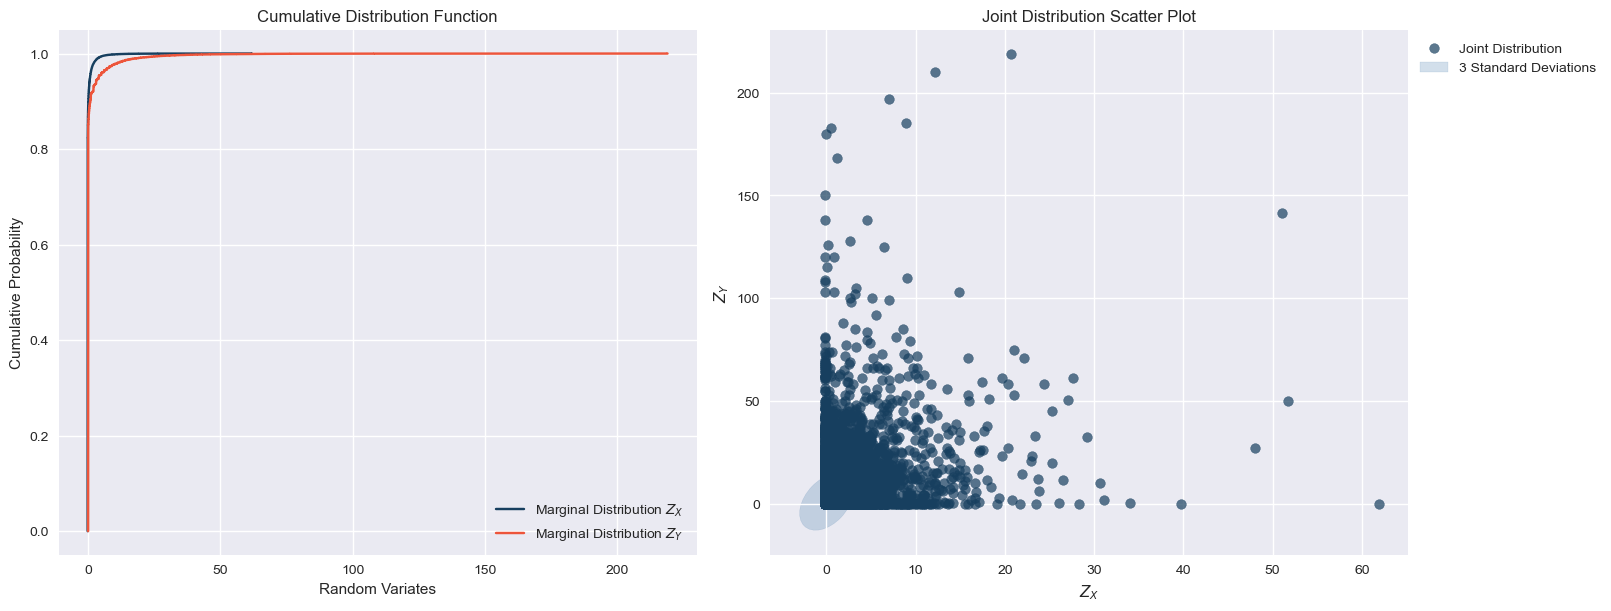

In [51]:

Z_x = X
Z_y = Y

n= len(X)
### Emperical CDF
cdf_y = np.arange(1, n+1) / n
X_cdf_x = np.sort(Z_x)
Y_cdf_x = np.sort(Z_y)

### Correlation
correlation_sample = np.corrcoef(X, Y)

### Expected Value
X_mean = np.mean(Z_x)
Y_mean = np.mean(Z_y)

X2 = np.square(Z_x)
Y2 = np.square(Z_y)

### Variance
var = (np.mean(X2)*np.mean(Y2)) - ((np.mean(X)**2)*(np.mean(Y)**2))

print("Sample Expected Value: ({:,.2f},{:,.2f})".format(X_mean, Y_mean))
print("Sample Variance: {:,.2f}".format(var))

### Plot the sampled PDF and CDF against the theoretical distribution
fig, ax = plt.subplots(figsize=(16,6), nrows=1, ncols=2)

ax[0].step(X_cdf_x, cdf_y, where='post', color=c1, label=r"Marginal Distribution $Z_X$")
ax[0].step(Y_cdf_x, cdf_y, where='post', color=c5, label=r"Marginal Distribution $Z_Y$")
ax[0].set(title="Cumulative Distribution Function", xlabel="Random Variates", ylabel="Cumulative Probability")
ax[0].legend()

ax[1].scatter(Z_x, Z_y, color=c1, alpha=0.7, label="Joint Distribution")
confidence_ellipse(Z_x, Z_y, ax=ax[1],alpha=0.2, facecolor=c2, edgecolor=c2, zorder=0, label="3 Standard Deviations",)
ax[1].set(title="Joint Distribution Scatter Plot", xlabel=r"$Z_X$", ylabel=r"$Z_Y$")
ax[1].legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [61]:
def copula_gaussian(Z_x  , Z_y ):
    
    ''' Normally distributed random variates X and Y with correlation 'p'
    '''
    
    # Independed Normal distributions

    correlation = np.corrcoef(Z_y, Z_y)[0,1]

    Z = np.matrix([Z_x, Z_y])
    
    # Construct the correlation matrix and Cholesky Decomposition
    rho = np.matrix([[1, correlation], [correlation, 1]])
    cholesky = np.linalg.cholesky(rho)
    
    # Apply Cholesky and extract X and Y
    Z_XY = cholesky * Z
    X = np.array(Z_XY[0,:]).flatten()
    Y = np.array(Z_XY[1,:]).flatten()
    
    # CDF
    X_cdf = sp.stats.norm.cdf(X, loc=0, scale=1)
    Y_cdf = sp.stats.norm.cdf(Y, loc=0, scale=1)
    
    return X, Y, X_cdf, Y_cdf


def copula_t(Zx, Zy):
    
    ''' Student's t distributed random variates t_X and t_Y with correlation 'p'
        and degrees of freedom 'df'
    '''
    
    # Gaussian Copula
    Zx, Zy, _, _ = copula_gaussian(Zx, Zy)
    n = len(Zx)
    # Chi Squared Sample
    n= np.random.seed(123)

    ChiSquared = np.random.chisquare(df=df, size=n)

    # Stident's t distributed random variables
    X = Zx / (np.sqrt(ChiSquared / df))
    Y = Zy / (np.sqrt(ChiSquared / df))
    
    # CDF
    X_cdf = sp.stats.t.cdf(X, df=df, loc=0, scale=1)
    Y_cdf = sp.stats.t.cdf(Y, df=df, loc=0, scale=1)
    
    return X, Y, X_cdf, Y_cdf

Tx, Ty, Tx_cdf, Ty_cdf  = copula_t(X, Y)

TypeError: float() argument must be a string or a number, not 'dict'

In [85]:
from copulas.multivariate import GaussianMultivariate

copula = GaussianMultivariate()
copula.fit(df['train'][ord_Keys])



C:\Users\Reza\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Reza\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
C:\Users\Reza\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Reza\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Reza\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_continuous_distns.py:4789: RuntimeWarning: divide by zero encountered in power
c:\Users\Reza\anaconda3\envs\Reza\lib\site-packages\copulas\univariate\truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (

In [90]:
copula.cdf(df['train'][ord_Keys])

array([0.73192495, 0.97194665, 0.89776679, ..., 0.25998707, 0.25998576,
       0.25998919])

KeyError: "None of [Index(['ANN_1', 'ELM_1', 'RF_1'], dtype='object')] are in the [columns]"

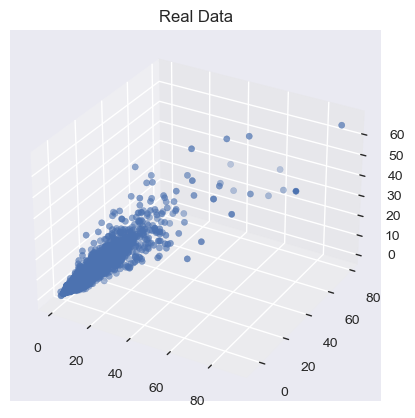

In [82]:
from copulas.visualization import compare_3d

compare_3d( df['test'][ord_Keys]  , synthetic_data)

In [84]:
df['test'][ord_Keys]

,ANN_1,ELM_1,RF_1
0,0.053674,-0.511442,0.031286
1,0.036088,-0.311485,0.028978
2,-0.013838,0.172979,0.028213
3,0.516255,0.896417,1.066874
4,0.426910,0.644803,0.150834
...,...,...,...
37579,43.312874,33.335351,48.979456
37580,4.645259,8.174365,7.641998
37581,6.986377,4.367971,6.110105
37582,4.002492,4.626384,4.272795


In [72]:
from copulas.datasets import sample_trivariate_xyz
real_data = sample_trivariate_xyz()
real_data

,x,y,z
0,9.004177e-05,2.883992e-06,0.638689
1,8.819273e-01,2.911979e-07,1.058121
2,5.003865e-01,4.886504e-04,0.372506
3,1.838544e-12,5.392802e-02,0.687370
4,1.627915e-01,1.634269e-08,-0.881068
...,...,...,...
995,7.344071e-05,5.015984e-02,2.697822
996,1.475430e-15,7.183602e-01,7.676588
997,9.956023e-01,7.138870e-09,-0.057518
998,1.000000e+00,1.709259e-05,1.075514
